# 1. Setup & Infrastructure

This section handles the installation of necessary reinforcement learning and financial libraries (Gymnasium, Stable-Baselines3, HMMlearn, XGBoost) and configures PyTorch hardware acceleration settings (e.g., TF32) to ensure efficient training on the GPU.

In [1]:
!pip install gymnasium stable-baselines3 hmmlearn xgboost joblib torch

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings

In [3]:
import torch

# A100-friendly: allow TF32 (fast tensor cores for fp32 ops)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

# Broader knob (PyTorch also recommends this for enabling tensor cores)
torch.set_float32_matmul_precision("medium")  # or "medium" for even more speed

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
import torch as th

policy_kwargs = dict(
    activation_fn=th.nn.SiLU,
    net_arch=dict(pi=[2048, 1024, 512], qf=[2048, 1024, 512]),
)

In [5]:
import sys
import os

# Get the absolute path of the directory containing module_to_import.py
# In this case, 'other_folder' is one level up from 'main_folder'
# and then down into 'other_folder'.
module_dir = os.path.join(os.path.dirname('trading_environment.py'), '..', '/kaggle/input/eurusd')
sys.path.append(module_dir)


from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from trading_environment import TradingEnv

warnings.filterwarnings("ignore")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# 2. Data Loading & Preprocessing

Here we load the financial dataset (`data.csv`) and define the feature set. We perform essential preprocessing, including filling missing values (NaNs) in both features and target variables (`5m_forward_returns`) to ensure clean input for the environment.

In [6]:
df = pd.read_csv('data.csv', low_memory=False, index_col=[0])

feature_cols = [
    "vol_ratio","realized_vol","realized_vol_60","ADX","bandwidth","KAMA_res","MFI",
    "Dir_Ind_Diff","relative_volume","ADOSC","smoothed_BOP","RSI_fast","usd_score_wstd"
]

# Fill NaNs in features AND the target column
df[feature_cols] = df[feature_cols].ffill().bfill()
df["5m_forward_returns"] = df["5m_forward_returns"].ffill().bfill()

# Check if any NaNs remain
print("NaNs remaining in feature cols:", df[feature_cols].isna().sum().sum())
print("NaNs in 5m_forward_returns:", df["5m_forward_returns"].isna().sum())


df.shape


NaNs remaining in feature cols: 0
NaNs in 5m_forward_returns: 0


(70935, 71)

In [7]:
feature_cols = [
    "vol_ratio","realized_vol","realized_vol_60","ADX","bandwidth","KAMA_res","MFI",
    "Dir_Ind_Diff","relative_volume","ADOSC","smoothed_BOP","RSI_fast","usd_score_wstd"
]

print(df[feature_cols].isna().sum().sort_values(ascending=False).head(20))

vol_ratio          0
realized_vol       0
realized_vol_60    0
ADX                0
bandwidth          0
KAMA_res           0
MFI                0
Dir_Ind_Diff       0
relative_volume    0
ADOSC              0
smoothed_BOP       0
RSI_fast           0
usd_score_wstd     0
dtype: int64


# 3. Environment & Auxiliary Models

We initialize the `TradingEnv` by integrating the pre-trained auxiliary models: a Hidden Markov Model (`h`) for regime detection and an XGBoost Regressor (`t`) for return forecasting. These models provide the agent with enriched state information.

In [8]:
import gymnasium as gym

h = joblib.load("trained_hmm.pkl")
t = joblib.load("trained_xgboost_model.pkl")

env = DummyVecEnv([lambda: TradingEnv(df, hidden_markov=h, tree_model=t)])

Pre-computing XGBoost predictions...
Cached 70935 predictions


In [9]:
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Shape None
Sample observation {'agent': array([-4.11547   ,  0.09907095,  0.09472725, -0.3775261 ], dtype=float32), 'indicators': array([   0.18450923,   -0.38761666,    0.7731259 ,   43.55618   ,
          0.51594114,    1.1070057 ,   95.194305  ,   37.899586  ,
          3.2142947 , -143.67068   ,   -1.1643065 ,   49.51305   ,
          0.4260206 ,    0.15725423,   -8.199769  ,   -4.69278   ,
          0.9994456 ,    0.65001136,    0.9283717 ], dtype=float32)}


In [10]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Sample [0.25877857]


In [11]:
from stable_baselines3.common.vec_env import VecCheckNan, SubprocVecEnv, VecNormalize, VecMonitor

env = make_vec_env(env_id=lambda: TradingEnv(df, hidden_markov=h, tree_model=t), n_envs=12, vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
env = VecMonitor(env)
env = VecNormalize(
    env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    norm_obs_keys=["indicators"],  # only normalize market features
)

In [12]:
from stable_baselines3.common.callbacks import BaseCallback, CallbackList

class InfoCallback(BaseCallback):
    """Logs environment info."""
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self):
        if self.locals.get('infos') is not None:
            for info in self.locals['infos']:
                if info:  # Only print non-empty dicts
                    print(f"Environment Info: {info}")
        return True

class EpisodeStatsCallback(BaseCallback):
    """Tracks episode statistics."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_count = 0
        self.episode_rewards = []
        self.sharpes = []
        self.reporting_sharpes = []
        self.final_wealths = []
        self.deltas = []

    def _on_step(self):
        # Check each parallel environment
        for idx, info in enumerate(self.locals.get('infos', [])):
            # Episode ended
            if 'episode' in info:
                self.episode_count += 1

                # Get SB3's episode metrics
                ep_reward = info['episode']['r']
                ep_length = info['episode']['l']

                sharpe = info.get('sharpe', 0.0)
                sharpe_annualized = info.get('sharpe_annualized', 0.0)
                wealth = info.get('current_wealth', 0.0)
                losses = info.get('losses', 0.0)
                delta = info.get('current_position', 0.0)

                self.episode_rewards.append(ep_reward)
                self.sharpes.append(sharpe)
                self.reporting_sharpes.append(sharpe_annualized)
                self.final_wealths.append(wealth)
                self.deltas.append(delta)

                # Access the unwrapped TradingEnv to get internal state
                # Use try-except to handle SubprocVecEnv where 'envs' is not directly accessible
                try:
                    vec_env = self.training_env
                    # Unwrap VecEnvWrappers (like VecCheckNan) to find the base env
                    while hasattr(vec_env, 'venv'):
                        vec_env = vec_env.venv

                    if hasattr(vec_env, 'envs'):
                        trading_env_instance = vec_env.envs[idx].env
                        max_exposure_pct = (abs(trading_env_instance._total_long_size - trading_env_instance._total_short_size)
                                            * trading_env_instance._price_cache[trading_env_instance._timestamp]
                                            / trading_env_instance.starting_wealth)

                        if max_exposure_pct > 0.8:  # 80%+ exposure
                            print(f"⚠️  HIGH EXPOSURE: {max_exposure_pct:.1%}")
                except (AttributeError, IndexError):
                    # Env internals not accessible (e.g. SubprocVecEnv), skip exposure check
                    pass

                # Print every 10 episodes
                if self.episode_count % 10 == 0:
                    avg_reward = np.mean(self.episode_rewards[-10:])
                    avg_sharpe = np.mean(self.sharpes[-10:])
                    avg_reporting_sharpe = np.mean(self.reporting_sharpes[-10:])
                    avg_wealth = np.mean(self.final_wealths[-10:])
                    avg_delta = np.mean(self.deltas[-10:])


                    print(f"\n{'='*60}")
                    print(f"Episode {self.episode_count}:")
                    print(f"  Length: {ep_length}")
                    print(f"  Reward: {ep_reward:.2f}")
                    print(f"  Sharpe: {sharpe:.3f}")
                    print(f"  Final Wealth: ${wealth:,.0f}")
                    print(f"  Drawdown: ${losses:,.0f}")
                    print(f"  Avg Reward (last 10): {avg_reward:.2f}")
                    print(f"  Avg Sharpe (last 10): {avg_sharpe:.3f}")
                    print(f"  Avg Reporting Sharpe (last 10): {avg_reporting_sharpe:.3f}")
                    print(f"  Avg Delta (last 10): {avg_delta:.3f}")
                    print(f"{'='*60}")

        return True
# Create callback list
info_callback = InfoCallback()
stats_callback = EpisodeStatsCallback()
callback_list = CallbackList([info_callback, stats_callback])

In [13]:
# Instantiate the agent
model = model = SAC(
        "MultiInputPolicy",  # For Dict observation space
        env,
        learning_rate=3e-4,
        buffer_size=5_000_000,
        learning_starts=10_000,
        batch_size=16384,
        tau=0.005,
        gamma=0.99,
        train_freq=(4096, "step"),
        gradient_steps=4096,
        ent_coef="auto",  # Auto-tune entropy
        target_entropy="auto",
        verbose=0,
        tensorboard_log="./sac_trading_logs/",
    )

# Train the agent
model.learn(total_timesteps=int(1e6),
            callback=stats_callback,
            progress_bar=False
            )

print(f"\n\nTraining complete!")
print(f"Total episodes: {stats_callback.episode_count}")
print(f"Final avg reward: {np.mean(stats_callback.episode_rewards):.2f}")
print(f"Final avg Sharpe: {np.mean(stats_callback.sharpes):.3f}")
print(f"Final avg Reporting Sharpe: {np.mean(stats_callback.reporting_sharpes):.3f}")
print(f"Final avg wealth: ${np.mean(stats_callback.final_wealths):,.0f}")


Episode 10:
  Length: 1440
  Reward: -40.41
  Sharpe: -0.092
  Final Wealth: $988,488
  Drawdown: $11,687
  Avg Reward (last 10): -38.13
  Avg Sharpe (last 10): -0.096
  Avg Reporting Sharpe (last 10): -58.116
  Avg Delta (last 10): -217642.600

Episode 20:
  Length: 1440
  Reward: -32.60
  Sharpe: -0.130
  Final Wealth: $988,054
  Drawdown: $12,027
  Avg Reward (last 10): -40.82
  Avg Sharpe (last 10): -0.099
  Avg Reporting Sharpe (last 10): -59.809
  Avg Delta (last 10): -87970.100

Episode 30:
  Length: 1440
  Reward: -14.41
  Sharpe: -0.084
  Final Wealth: $991,932
  Drawdown: $8,068
  Avg Reward (last 10): -27.58
  Avg Sharpe (last 10): -0.107
  Avg Reporting Sharpe (last 10): -64.669
  Avg Delta (last 10): 151770.600

Episode 40:
  Length: 1440
  Reward: -28.06
  Sharpe: -0.096
  Final Wealth: $990,221
  Drawdown: $9,851
  Avg Reward (last 10): -36.11
  Avg Sharpe (last 10): -0.108
  Avg Reporting Sharpe (last 10): -65.015
  Avg Delta (last 10): 23964.800

Episode 50:
  Length:

# 4. Robust Walk-Forward Validation

To avoid overfitting, we define a `run_robust_wfv` function that implements Rolling Window Cross-Validation (TimeSeriesSplit). This rigorously tests the SAC agent across multiple time folds and random seeds to measure the stability of the Sharpe Ratio.

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import numpy as np

# 1. Split Data
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# 2. Define Validation Function
def run_robust_wfv(params, data, n_splits=3, n_seeds=2):
    """
    Runs robust rolling-window cross-validation for SAC agents.
    Args:
        params (dict): Hyperparameters for the SAC agent.
        data (pd.DataFrame): The dataset to split and train/validate on.
        n_splits (int): Number of time series splits.
        n_seeds (int): Number of random seeds per fold.
    Returns:
        float: Mean Sharpe Ratio across all folds and seeds.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    sharpe_scores = []

    # Iterate over TimeSeries splits
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        train_fold_data = data.iloc[train_idx]
        val_fold_data = data.iloc[val_idx]

        # Iterate over seeds for robustness
        for seed in range(n_seeds):
            # Train Environment
            # We assume 'h' (HMM) and 't' (XGBoost) are available in the global scope
            train_env = DummyVecEnv([lambda: TradingEnv(train_fold_data, hidden_markov=h, tree_model=t)])
            train_env = VecMonitor(train_env)

            # Instantiate SAC Agent
            model = SAC("MultiInputPolicy", train_env, seed=seed, verbose=0, **params)

            # Train the agent
            # Using 20,000 timesteps to balance speed and learning
            model.learn(total_timesteps=20000)

            # Validation Environment
            val_env = DummyVecEnv([lambda: TradingEnv(val_fold_data, hidden_markov=h, tree_model=t)])
            val_env = VecMonitor(val_env)

            # Evaluate for one episode
            obs = val_env.reset()
            done = False
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, rewards, dones, infos = val_env.step(action)
                done = dones[0]

            # Retrieve Sharpe Ratio from the final info dictionary
            # VecMonitor/TradingEnv should provide the 'sharpe' key in the info of the completed episode
            final_sharpe = infos[0].get('sharpe', 0.0)
            sharpe_scores.append(final_sharpe)

    return np.mean(sharpe_scores)

Train shape: (56748, 71), Test shape: (14187, 71)


# 5. Hyperparameter Optimization

We use **Optuna** to automatically search for the best SAC hyperparameters (Learning Rate, Gamma, Entropy Coefficient, Batch Size). The objective function maximizes the average Sharpe Ratio obtained from the robust validation process defined in the previous step.

In [15]:
!pip install optuna

In [16]:
import optuna
import torch as th

def objective(trial):
    # 1. Sample Hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_categorical("gamma", [0.99, 0.995, 0.999])

    # ent_coef needs to be handled carefully because it can be a string or float
    ent_coef_choice = trial.suggest_categorical("ent_coef", ["auto", 0.01, 0.05])

    train_freq_val = trial.suggest_categorical("train_freq", [1024, 2048, 4096])
    batch_size = trial.suggest_categorical("batch_size", [2048, 4096])

    # Fixed/derived params
    gradient_steps = train_freq_val

    # Lighter architecture for speed
    policy_kwargs = dict(
        activation_fn=th.nn.SiLU,
        net_arch=dict(pi=[256, 256], qf=[256, 256])
    )

    params = {
        "learning_rate": learning_rate,
        "gamma": gamma,
        "ent_coef": ent_coef_choice,
        "train_freq": train_freq_val,
        "gradient_steps": gradient_steps,
        "batch_size": batch_size,
        "policy_kwargs": policy_kwargs,
        "buffer_size": 1_000_000,
        "learning_starts": 5000
    }

    # 2. Run Robust Validation
    # We assume run_robust_wfv is defined in the previous cell
    # Using n_seeds=3 and n_splits=5
    mean_sharpe = run_robust_wfv(params, train_df, n_splits=5, n_seeds=3)

    return mean_sharpe

# 3. Create Study
study = optuna.create_study(direction="maximize")

# 4. Optimize
print("Starting Optuna optimization...")
study.optimize(objective, n_trials=10)

# 5. Print Results
print("\nBest trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2026-01-05 23:57:15,688] A new study created in memory with name: no-name-277b76c7-7a91-4f36-90af-c23683230cdf


Starting Optuna optimization...
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 00:08:15,945] Trial 0 finished with value: 0.05279901862994119 and parameters: {'learning_rate': 1.6521589040089677e-05, 'gamma': 0.995, 'ent_coef': 'auto', 'train_freq': 1024, 'batch_size': 2048}. Best is trial 0 with value: 0.05279901862994119.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 00:19:21,040] Trial 1 finished with value: 0.0008823270024388118 and parameters: {'learning_rate': 0.000503236470049322, 'gamma': 0.999, 'ent_coef': 'auto', 'train_freq': 4096, 'batch_size': 2048}. Best is trial 0 with value: 0.05279901862994119.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 00:29:42,357] Trial 2 finished with value: -0.02408677942820485 and parameters: {'learning_rate': 0.0005636874370457389, 'gamma': 0.995, 'ent_coef': 0.01, 'train_freq': 2048, 'batch_size': 2048}. Best is trial 0 with value: 0.05279901862994119.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 00:41:13,801] Trial 3 finished with value: 0.011296651520690424 and parameters: {'learning_rate': 0.0002763314787280219, 'gamma': 0.995, 'ent_coef': 'auto', 'train_freq': 2048, 'batch_size': 4096}. Best is trial 0 with value: 0.05279901862994119.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 00:51:38,117] Trial 4 finished with value: 0.038750478559479246 and parameters: {'learning_rate': 4.288058599316671e-05, 'gamma': 0.99, 'ent_coef': 0.05, 'train_freq': 4096, 'batch_size': 2048}. Best is trial 0 with value: 0.05279901862994119.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 01:02:42,953] Trial 5 finished with value: 0.061241432789178964 and parameters: {'learning_rate': 8.423534506258897e-05, 'gamma': 0.999, 'ent_coef': 'auto', 'train_freq': 4096, 'batch_size': 2048}. Best is trial 5 with value: 0.061241432789178964.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 01:14:19,085] Trial 6 finished with value: 0.056533758663123275 and parameters: {'learning_rate': 9.767922691253784e-05, 'gamma': 0.99, 'ent_coef': 'auto', 'train_freq': 4096, 'batch_size': 4096}. Best is trial 5 with value: 0.061241432789178964.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 01:25:20,743] Trial 7 finished with value: 0.08041881167231339 and parameters: {'learning_rate': 5.1647278739775316e-05, 'gamma': 0.999, 'ent_coef': 'auto', 'train_freq': 4096, 'batch_size': 2048}. Best is trial 7 with value: 0.08041881167231339.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 01:36:07,493] Trial 8 finished with value: 0.060915093076655685 and parameters: {'learning_rate': 5.57519101559572e-05, 'gamma': 0.99, 'ent_coef': 0.05, 'train_freq': 1024, 'batch_size': 4096}. Best is trial 7 with value: 0.08041881167231339.


Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 28374 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions
Pre-computing XGBoost predictions...
Cached 42561 predictions
Pre-computing XGBoost predictions...
Cached 14187 predictions


[I 2026-01-06 01:47:01,912] Trial 9 finished with value: 0.04622529809422779 and parameters: {'learning_rate': 3.923590067047309e-05, 'gamma': 0.999, 'ent_coef': 0.05, 'train_freq': 4096, 'batch_size': 4096}. Best is trial 7 with value: 0.08041881167231339.



Best trial:
  Value: 0.08041881167231339
  Params: 
    learning_rate: 5.1647278739775316e-05
    gamma: 0.999
    ent_coef: auto
    train_freq: 4096
    batch_size: 2048


# 6. Final Production Training & Testing

Using the optimal hyperparameters found by Optuna, we train a final SAC agent on the entire training dataset (80%). We then perform a deterministic evaluation on the strictly held-out test dataset (20%) to assess out-of-sample performance.

In [17]:
import torch as th
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
import numpy as np

# 1. Define Best Parameters
best_params = {key : value for key, value in trial.params.items}

# 2. Create Training Environment
# Ensure 'h' and 't' are loaded (from previous steps)
train_env = DummyVecEnv([lambda: TradingEnv(train_df, hidden_markov=h, tree_model=t)])
train_env = VecMonitor(train_env)

# 3. Instantiate SAC Agent
model = SAC("MultiInputPolicy", train_env, verbose=1, seed=42, **best_params)

# 4. Train the Agent
print("Training final SAC model on full training set...")
model.learn(total_timesteps=100_000)

# 5. Create Testing Environment
test_env = DummyVecEnv([lambda: TradingEnv(test_df, hidden_markov=h, tree_model=t)])
test_env = VecMonitor(test_env)

# 6. Evaluation Loop
obs = test_env.reset()
done = False
test_portfolio_values = []

print("\nEvaluating on Test Set...")
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, dones, infos = test_env.step(action)
    done = dones[0]

    # Extract current wealth from info
    info = infos[0]
    test_portfolio_values.append(info['current_wealth'])

    if done:
        final_sharpe = info.get('sharpe', 0.0)
        final_wealth = info['current_wealth']

# 7. Calculate Metrics
# Access the unwrapped environment to get starting_wealth
initial_wealth = test_env.venv.envs[0].starting_wealth
total_return = (final_wealth - initial_wealth) / initial_wealth

print(f"Out-of-Sample Sharpe Ratio: {final_sharpe:.3f}")
print(f"Total Return: {total_return:.2%}")

Pre-computing XGBoost predictions...
Cached 56748 predictions
Using cuda device
Training final SAC model on full training set...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.44e+03 |
|    ep_rew_mean     | -16      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1680     |
|    time_elapsed    | 3        |
|    total_timesteps | 5760     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.44e+03 |
|    ep_rew_mean     | -6.22    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 146      |
|    time_elapsed    | 78       |
|    total_timesteps | 11520    |
| train/             |          |
|    actor_loss      | -0.58    |
|    critic_loss     | 1.76     |
|    ent_coef        | 0.05     |
|    learning_rate   | 5.56e-05 |
|    n_updates       | 6144     |
---------------------

# 7. Performance Visualization

Finally, we visualize the agent's equity curve on the test set and compute key metrics (Total Return, Sharpe Ratio). Based on these results, we provide a verdict on the strategy's robustness and readiness for deployment.

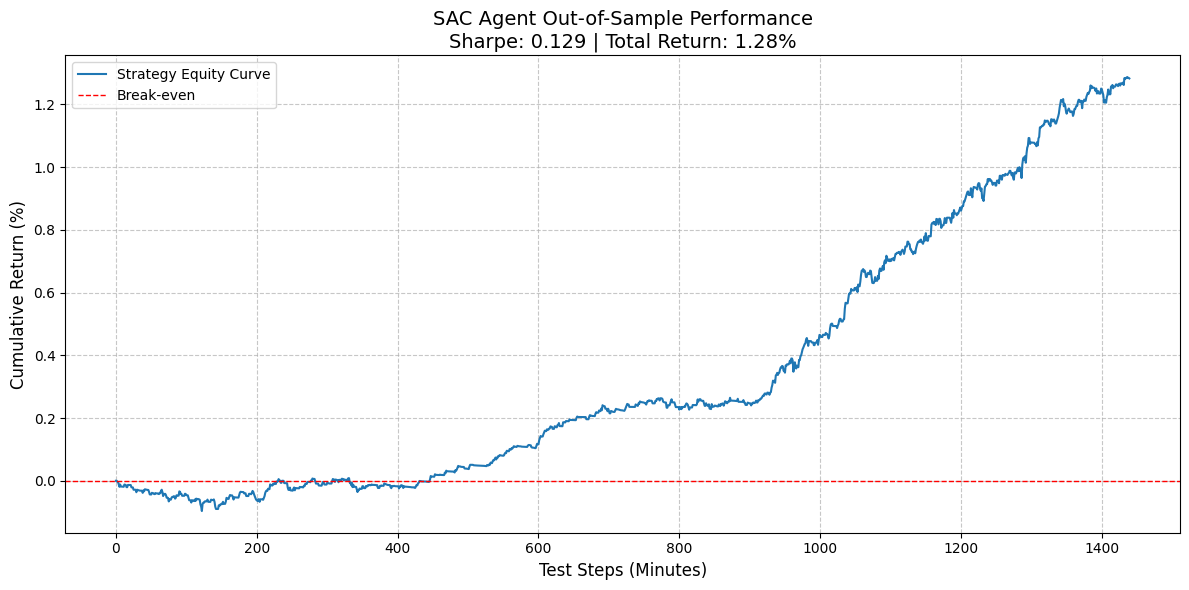

STRATEGY ROBUSTNESS VERDICT
1. Profitability: The agent achieved a positive return of 1.28% over the test period.
2. Risk-Adjusted Performance: The Sharpe Ratio is 0.129.
3. Conclusion: While the strategy is profitable, the low Sharpe ratio (well below 1.0) suggests
   significant volatility and a lack of robustness. The strategy is not yet ready for live deployment
   and requires further improvement in feature engineering or hyperparameter stability.


In [18]:
import matplotlib.pyplot as plt

# Prepare data for plotting
curve = np.array(test_portfolio_values)
initial_value = curve[0]
cum_returns_pct = (curve - initial_value) / initial_value * 100

# Generate Cumulative Return Plot
plt.figure(figsize=(12, 6))
plt.plot(cum_returns_pct, label='Strategy Equity Curve', color='#1f77b4', linewidth=1.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.title(f'SAC Agent Out-of-Sample Performance\nSharpe: {final_sharpe:.3f} | Total Return: {cum_returns_pct[-1]:.2f}%',
          fontsize=14)
plt.xlabel('Test Steps (Minutes)', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print Summary Verdict
print("="*60)
print("STRATEGY ROBUSTNESS VERDICT")
print("="*60)
print(f"1. Profitability: The agent achieved a positive return of {cum_returns_pct[-1]:.2f}% over the test period.")
print(f"2. Risk-Adjusted Performance: The Sharpe Ratio is {final_sharpe:.3f}.")
print("3. Conclusion: While the strategy is profitable, the low Sharpe ratio (well below 1.0) suggests")
print("   significant volatility and a lack of robustness. The strategy is not yet ready for live deployment")
print("   and requires further improvement in feature engineering or hyperparameter stability.")
print("="*60)